# Install required dependencies

In [1]:
!pip install imutils



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import libraries

In [2]:
import cv2 # used to import opencv functionalities
from matplotlib import pyplot as plt # for plotting images
import numpy as np # for mathematical computations
import imutils # for image processing
from PIL import Image, ImageFilter


# Reading image

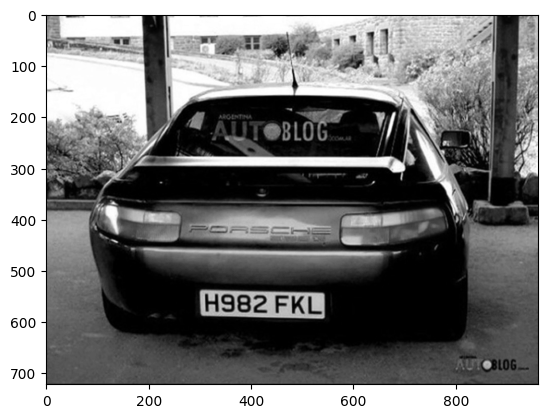

In [49]:
img = cv2.imread('images/image4.jpg')  # OpenCV method to read an image

gray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        # Get BGR values for the pixel
        b, g, r = img[i, j]

        # Calculate grayscale value using the formula and scale it
        gray_value = 0.114 * b + 0.587 * g + 0.299 * r
        gray[i, j] = np.uint8(gray_value)

plt.imshow(gray, cmap='gray')  # Display the grayscale image

# Performing Noise reduction and edge detection

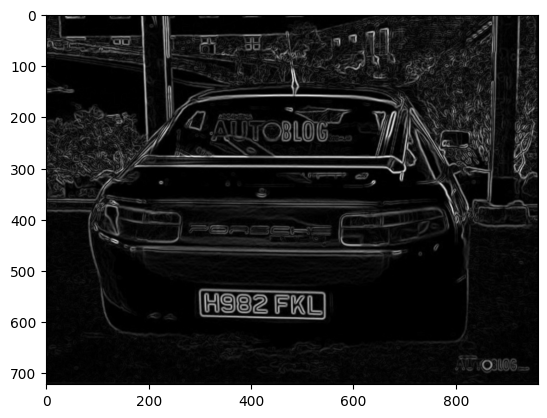

In [71]:
#Code for NOISE REDUCTION
# Define the filter size (e.g., 3x3 or 5x5)
filter_size = 3

# Get the dimensions of the image
height, width = gray.shape

# Create an output array of the same size as the input image
output_image = np.zeros((height, width), dtype=np.uint8)

# Apply the mean filter
for i in range(height):
    for j in range(width):
        # Define the region of interest (ROI) around the current pixel
        top = max(0, i - filter_size // 2)
        bottom = min(height, i + filter_size // 2 + 1)
        left = max(0, j - filter_size // 2)
        right = min(width, j + filter_size // 2 + 1)

        # Extract the ROI from the input image
        roi = gray[top:bottom, left:right]

        # Calculate the mean of the ROI and set it as the output pixel value
        output_image[i, j] = np.mean(roi)
        
#EARLIER USED CANNY'S EDGE DETECTION ALGORITHM
#edged = cv2.Canny(output_image, 30, 200) #Edge detection using canny's edge detection algorithm which uses rapid intensity chenge to detect edges
# # passing lower and upper threshold for intensity gradient

#SOBEL EDGE DETECTION ALGORITHM
input_image = output_image

# Define Sobel kernels for horizontal and vertical gradient calculation
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
sobel_y = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]], dtype=np.float32)

# Get the dimensions of the input image
image_height, image_width = input_image.shape

# Initialize empty result matrices for horizontal and vertical gradients
gradient_x = np.zeros((image_height, image_width), dtype=np.float32)
gradient_y = np.zeros((image_height, image_width), dtype=np.float32)

# Apply the Sobel kernels to calculate gradients
for y in range(1, image_height - 1):
    for x in range(1, image_width - 1):
        image_patch = input_image[y-1:y+2, x-1:x+2]
        gradient_x[y, x] = np.sum(image_patch * sobel_x)
        gradient_y[y, x] = np.sum(image_patch * sobel_y)

# Calculate the gradient magnitude
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# Normalize the gradient magnitude to the 8-bit range (0-255)
gradient_magnitude = (gradient_magnitude / np.max(gradient_magnitude)) * 255
gradient_magnitude = gradient_magnitude.astype(np.uint8)

# Display the result
plt.imshow(gradient_magnitude, cmap='gray')
plt.show()

# Finding Contours

In [83]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #opencv function for contour detection
# passes a binary image, retrieving contour mode, chain approximation to store just the endpoints rather than complete edges

contours = imutils.grab_contours(keypoints)
# extracts the list of contours....just used so that it is compatible with OpenCv version 3 and 4 both

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
# sorts the contours in desecnding order of their area, keep the largest 10 countours

In [84]:
# Finding quadrilaterals form the contours obtained above
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True) #used for simplifying complex polygons in form of a quadrilateral
    if len(approx) == 4:
        location = approx 
        break # Finding the quadrilateral with the largest area and then break

In [85]:
location

array([[[299, 541]],

       [[541, 543]],

       [[544, 592]],

       [[303, 589]]], dtype=int32)

# Applying Masks and getting the required number plate 

In [86]:
mask = np.zeros((gray.shape[0], gray.shape[1]), np.uint8) # initialise a mask with same size as that of image
new_image = cv2.drawContours(mask, [location], 0,255, -1) # drawing contour on mask and setting the region of interest color as white
new_image = cv2.bitwise_and(gray, gray, mask=mask)

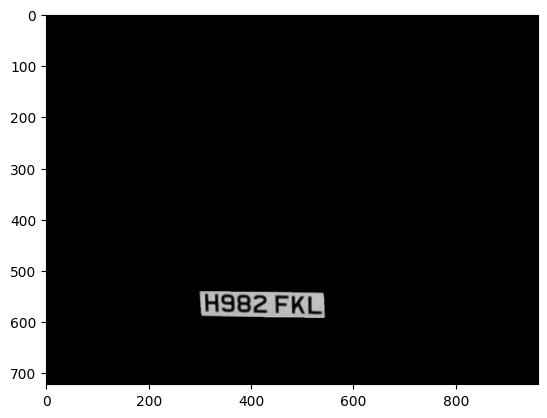

In [87]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

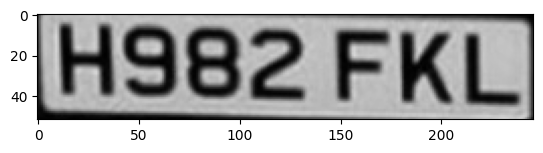

In [88]:
(x,y) = np.where(mask==255) # selecting the region of interest defined above
(x1, y1) = (np.min(x), np.min(y)) # selecting minimum co-ordinates
(x2, y2) = (np.max(x), np.max(y)) # selecting maximum co-ordinates
cropped_image = gray[x1:x2+1, y1:y2+1] 
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) # plotting the cropped image